<a href="https://colab.research.google.com/github/macgyver121/DADS7202_hw2/blob/main/hw2_v8(65_73)_17_10_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-51c7b44c-2534-3309-eee6-c97bda7e9dab)


In [ ]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]

NumPy 1.21.6

TensorFlow 2.9.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


## **** Mount + Import library ****

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

import tensorflow_hub as hub

from tensorflow.keras import layers
from tensorflow.keras import activations

## **** Import + Prepare Data ****

In [ ]:
### edit directory
###
###

data_directory = pathlib.Path('/content/drive/MyDrive/hw2_DADS7202_photo_4class')
class_names = [item.name for item in data_directory.glob('*')][0:]
class_names.sort()
print(class_names)

['class1', 'class2', 'class3', 'class4']


In [ ]:
### edit directory

class1_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class1'
class2_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class2'
class3_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class3'
class4_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class4'
data_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class'

In [ ]:
class1_images = len(os.listdir(class1_dir))
class2_images = len(os.listdir(class2_dir))
class3_images = len(os.listdir(class3_dir))
class4_images = len(os.listdir(class4_dir))

print(f'Number of class1 images: {class1_images}')
print(f'Number of class2 images: {class2_images}')
print(f'Number of class3 images: {class3_images}')
print(f'Number of class4 images: {class4_images}')

Number of class1 images: 211
Number of class2 images: 267
Number of class3 images: 200
Number of class4 images: 220


In [ ]:
### edit model
###
###

np.random.seed(1234)
tf.random.set_seed(5678)

# Defining data generator withour Data Augmentation
data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.3)

train_data = data_gen.flow_from_directory(data_dir, 
                                          target_size = (224, 224), 
                                          batch_size = 700,
                                          subset = 'training',
                                          class_mode = 'binary')
test_data = data_gen.flow_from_directory(data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = 300,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 629 images belonging to 4 classes.
Found 269 images belonging to 4 classes.


In [ ]:
x_train, y_train = train_data.next()
len(x_train), len(y_train), x_train[0].shape

(629, 629, (224, 224, 3))

In [ ]:
x_test, y_test = test_data.next()
len(x_test), len(y_test), x_test[0].shape

(269, 269, (224, 224, 3))

## EDA

In [ ]:
print( f"x_train: type={type(x_train)} , dtype={x_train.dtype} , shape={x_train.shape} , min={x_train.min(axis=None)} , max={x_train.max(axis=None)}" )
print( f"x_test: type={type(x_test)} , dtype={x_test.dtype} , shape={x_test.shape} , min={x_test.min(axis=None)} , max={x_test.max(axis=None)}" )

x_train: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(629, 224, 224, 3) , min=0.0 , max=1.0
x_test: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(269, 224, 224, 3) , min=0.0 , max=1.0


In [ ]:
df_train = pd.DataFrame(y_train, columns = ['class'])
df_test = pd.DataFrame(y_test, columns = ['class'])

In [ ]:
df_train_count = pd.DataFrame(df_train.groupby(['class'])['class'].count())
df_train_count

,class
class,
0.0,148
1.0,187
2.0,140
3.0,154


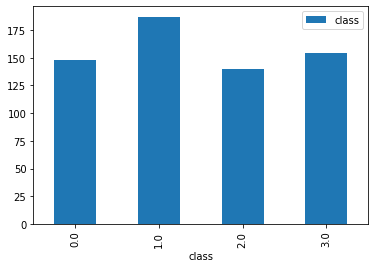

In [ ]:
df_train_count.plot.bar()

In [ ]:
df_test_count = pd.DataFrame(df_test.groupby(['class'])['class'].count())
df_test_count

,class
class,
0.0,63
1.0,80
2.0,60
3.0,66


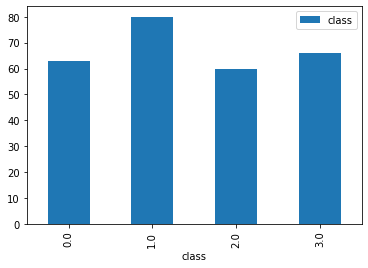

In [ ]:
df_test_count.plot.bar()

In [ ]:
for i in range(10) :
    print(y_train[i])

2.0
2.0
1.0
3.0
3.0
2.0
1.0
3.0
1.0
1.0


Each class size

In [ ]:
from PIL import Image

directories = {'Class_0': '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class1/',
'Class_1': '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class2/',
'Class_2': '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class3/',
'Class_3': '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class4/'}

def get_dims(file):
  im = Image.open(file)
  arr = np.array(im)
  h,w,d = arr.shape
  return h,w

In [ ]:
import dask.bag as bag
from dask.diagnostics import ProgressBar

for n,d in directories.items():
  filepath = d
  filelist = [filepath + f for f in os.listdir(filepath)]
  dims = bag.from_sequence(filelist).map(get_dims)

print(dims[0:10])

with ProgressBar():
  dims = dims.compute()
  dim_df = pd.DataFrame(dims, columns=['height', 'width'])
  sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
  sizes.plot.scatter(x='width', y='height');
  plt.title('Image Sizes (pixels) | {}'.format(n))

TypeError: ignored

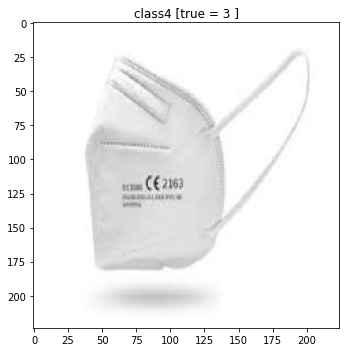

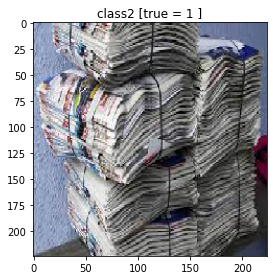

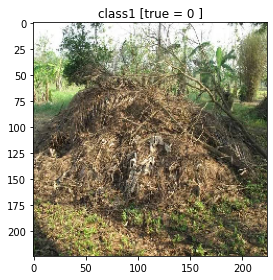

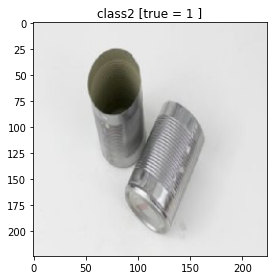

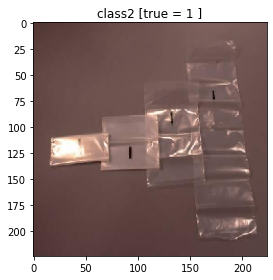

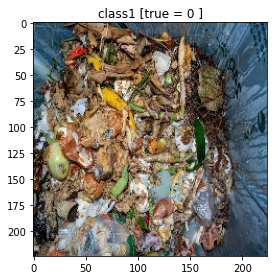

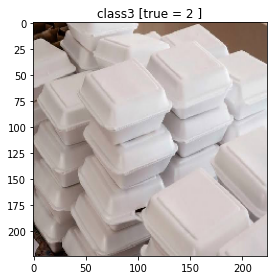

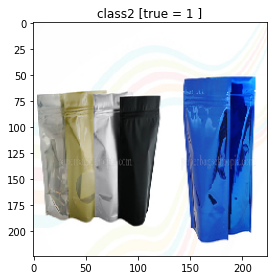

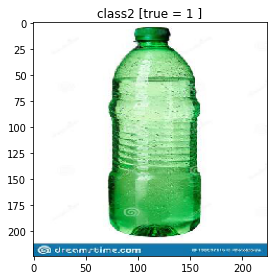

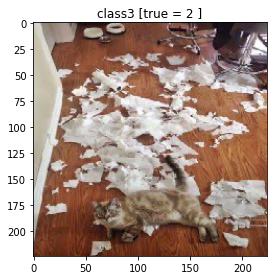

In [ ]:
# Visualize the first five images in x_train
plt.figure(figsize=(10,5))
for i in range(10,20):
    plt.title( f"{class_names[ int(y_train[i]) ]} [true = {int(y_train[i])} ]") 
    plt.imshow( x_train[i] )  
    plt.tight_layout()       
    plt.show()

# VGG-16

## Create the base model from the pre-trained convnets

In [ ]:
# Load the ImageNet VGG-16 model, including both the feature extractor part and the classifier part
# By default, VGG-16 is designed for an input image of dimension 224x224x3
img_w,img_h = 224,224
vgg_extractor = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))

vgg_extractor.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

## Feature Extractor

### Freeze the convolutional base

In [ ]:
vgg_extractor.trainable = False

for i,layer in enumerate(vgg_extractor.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_1 , trainable = False
Layer 1: name = block1_conv1 , trainable = False
Layer 2: name = block1_conv2 , trainable = False
Layer 3: name = block1_pool , trainable = False
Layer 4: name = block2_conv1 , trainable = False
Layer 5: name = block2_conv2 , trainable = False
Layer 6: name = block2_pool , trainable = False
Layer 7: name = block3_conv1 , trainable = False
Layer 8: name = block3_conv2 , trainable = False
Layer 9: name = block3_conv3 , trainable = False
Layer 10: name = block3_pool , trainable = False
Layer 11: name = block4_conv1 , trainable = False
Layer 12: name = block4_conv2 , trainable = False
Layer 13: name = block4_conv3 , trainable = False
Layer 14: name = block4_pool , trainable = False
Layer 15: name = block5_conv1 , trainable = False
Layer 16: name = block5_conv2 , trainable = False
Layer 17: name = block5_conv3 , trainable = False
Layer 18: name = block5_pool , trainable = False


### Add a classification head

In [ ]:
x = vgg_extractor.output

# Add our custom layer(s) to the end of the existing model 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model 
model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Plot Model

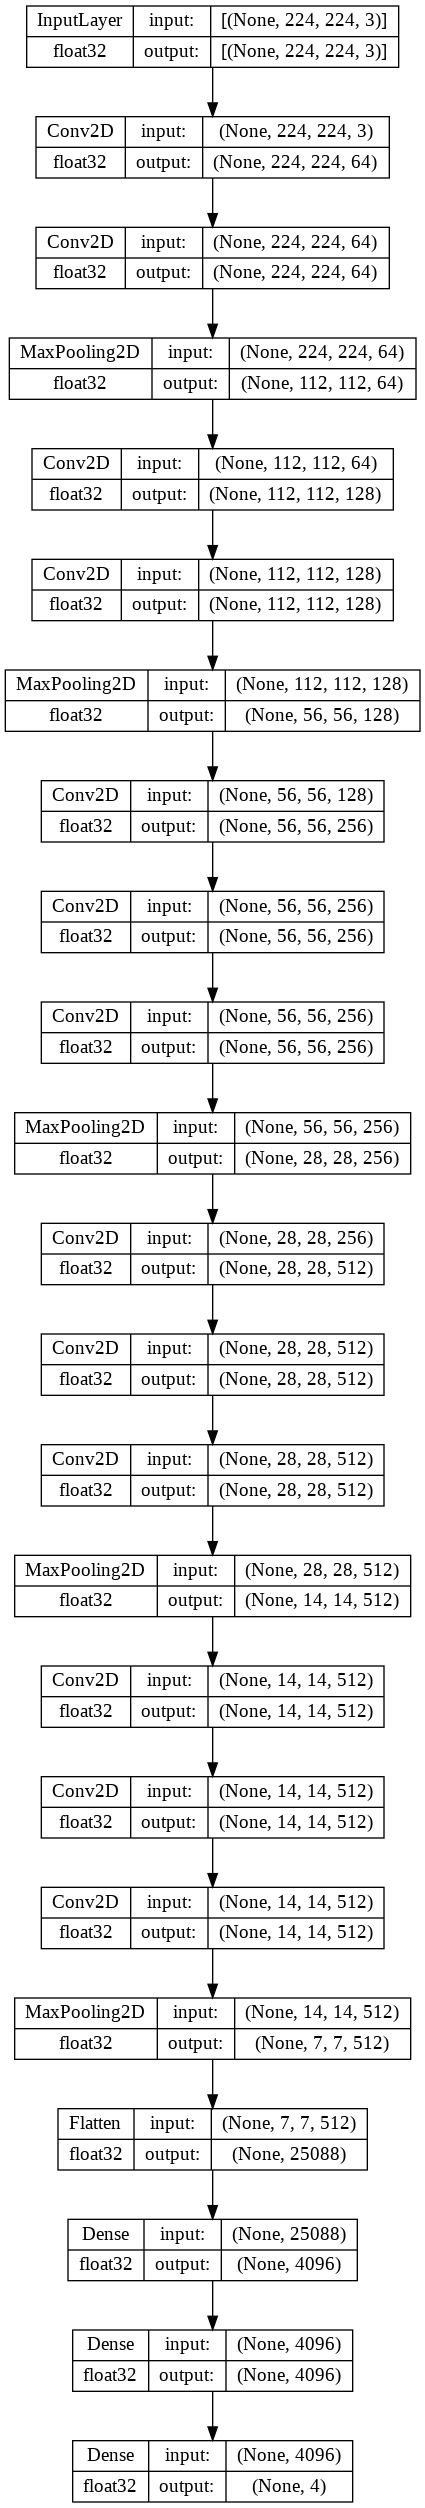

In [ ]:
tf.keras.utils.plot_model(model, to_file='vgg_original.png', show_shapes=True, show_dtype=True, show_layer_names=False, dpi=96)

### Preprocessing input

In [ ]:
np.random.seed(1234)
tf.random.set_seed(5678)

# Defining data generator withour Data Augmentation
data_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, rescale = 1/255., validation_split = 0.3)

train_data = data_gen.flow_from_directory(data_dir, 
                                          target_size = (224, 224), 
                                          batch_size = 700,
                                          subset = 'training',
                                          class_mode = 'binary')
test_data = data_gen.flow_from_directory(data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = 300,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 629 images belonging to 4 classes.
Found 269 images belonging to 4 classes.


In [ ]:
x_train, y_train = train_data.next()
x_test, y_test = test_data.next()

### Compile the model

In [ ]:
model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] )

### Train the model

In [ ]:
from datetime import datetime
start_time = datetime.now()

np.random.seed(1234)
tf.random.set_seed(5678)

from keras import callbacks

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)

history = model.fit( x_train , y_train, batch_size=10, epochs=10, verbose=1, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/10
44/44 [==============================] - ETA: 0s - loss: 4.9071 - acc: 0.5545
Epoch 1: val_acc improved from -inf to 0.70370, saving model to weights.hdf5
44/44 [==============================] - 22s 291ms/step - loss: 4.9071 - acc: 0.5545 - val_loss: 0.7927 - val_acc: 0.7037
Epoch 2/10
44/44 [==============================] - ETA: 0s - loss: 0.2929 - acc: 0.8886
Epoch 2: val_acc improved from 0.70370 to 0.71429, saving model to weights.hdf5
44/44 [==============================] - 11s 253ms/step - loss: 0.2929 - acc: 0.8886 - val_loss: 0.8828 - val_acc: 0.7143
Epoch 3/10
44/44 [==============================] - ETA: 0s - loss: 0.2697 - acc: 0.9114
Epoch 3: val_acc did not improve from 0.71429
44/44 [==============================] - 5s 115ms/step - loss: 0.2697 - acc: 0.9114 - val_loss: 2.1802 - val_acc: 0.6561
Epoch 4/10
44/44 [==============================] - ETA: 0s - loss: 0.2397 - acc: 0.9295
Epoch 4: val_acc improved from 0.71429 to 0.74603, saving model to weights.h

### Learning curves

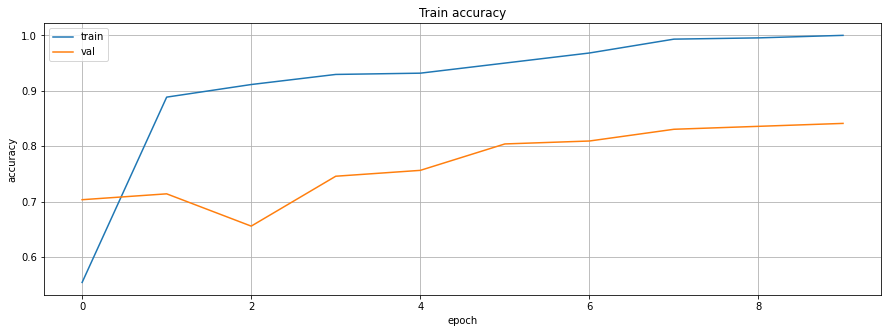

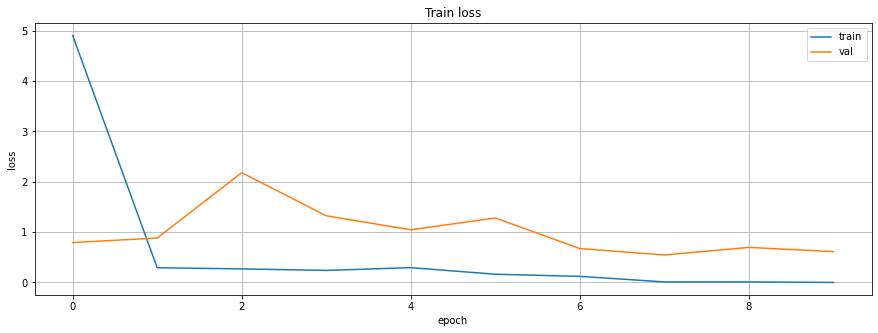

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

### Evaluate on test set

In [ ]:
# Evaluate the trained model on the test set
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

9/9 [==============================] - 5s 325ms/step - loss: 1.9554 - acc: 0.6691
['loss', 'acc']: [1.9553871154785156, 0.6691449880599976]
Duration: 0:00:05.606033


### Evaluate on test set without seed

In [ ]:
# create model
img_w,img_h = 224,224
vgg_extractor = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))
vgg_extractor.trainable = False
x = vgg_extractor.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)
model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)

#train model without seed
model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] )

start_time = datetime.now()

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)

history = model.fit( x_train , y_train, batch_size=10, epochs=10, verbose=1, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

#Evaluate on test set without seed
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/10
44/44 [==============================] - ETA: 0s - loss: 5.4743 - acc: 0.5682
Epoch 1: val_acc improved from -inf to 0.73016, saving model to weights.hdf5
44/44 [==============================] - 12s 271ms/step - loss: 5.4743 - acc: 0.5682 - val_loss: 0.6453 - val_acc: 0.7302
Epoch 2/10
44/44 [==============================] - ETA: 0s - loss: 0.2983 - acc: 0.9023
Epoch 2: val_acc improved from 0.73016 to 0.79365, saving model to weights.hdf5
44/44 [==============================] - 11s 262ms/step - loss: 0.2983 - acc: 0.9023 - val_loss: 0.5526 - val_acc: 0.7937
Epoch 3/10
44/44 [==============================] - ETA: 0s - loss: 0.2271 - acc: 0.9295
Epoch 3: val_acc improved from 0.79365 to 0.79894, saving model to weights.hdf5
44/44 [==============================] - 11s 262ms/step - loss: 0.2271 - acc: 0.9295 - val_loss: 0.7580 - val_acc: 0.7989
Epoch 4/10
44/44 [==============================] - ETA: 0s - loss: 0.0535 - acc: 0.9795
Epoch 4: val_acc improved from 0.79894 to

## Fine tuning

### Un-freeze the top layers of the model



In [ ]:
vgg_extractor.layers[-2].trainable = True
vgg_extractor.layers[-1].trainable = True

In [ ]:
for i,layer in enumerate(vgg_extractor.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_3 , trainable = False
Layer 1: name = block1_conv1 , trainable = False
Layer 2: name = block1_conv2 , trainable = False
Layer 3: name = block1_pool , trainable = False
Layer 4: name = block2_conv1 , trainable = False
Layer 5: name = block2_conv2 , trainable = False
Layer 6: name = block2_pool , trainable = False
Layer 7: name = block3_conv1 , trainable = False
Layer 8: name = block3_conv2 , trainable = False
Layer 9: name = block3_conv3 , trainable = False
Layer 10: name = block3_pool , trainable = False
Layer 11: name = block4_conv1 , trainable = False
Layer 12: name = block4_conv2 , trainable = False
Layer 13: name = block4_conv3 , trainable = False
Layer 14: name = block4_pool , trainable = False
Layer 15: name = block5_conv1 , trainable = False
Layer 16: name = block5_conv2 , trainable = False
Layer 17: name = block5_conv3 , trainable = True
Layer 18: name = block5_pool , trainable = True


### Add a classification head

In [ ]:
x = vgg_extractor.output

# Add our custom layer(s) to the end of the existing model 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model 
model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
for i,layer in enumerate(model.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_3 , trainable = False
Layer 1: name = block1_conv1 , trainable = False
Layer 2: name = block1_conv2 , trainable = False
Layer 3: name = block1_pool , trainable = False
Layer 4: name = block2_conv1 , trainable = False
Layer 5: name = block2_conv2 , trainable = False
Layer 6: name = block2_pool , trainable = False
Layer 7: name = block3_conv1 , trainable = False
Layer 8: name = block3_conv2 , trainable = False
Layer 9: name = block3_conv3 , trainable = False
Layer 10: name = block3_pool , trainable = False
Layer 11: name = block4_conv1 , trainable = False
Layer 12: name = block4_conv2 , trainable = False
Layer 13: name = block4_conv3 , trainable = False
Layer 14: name = block4_pool , trainable = False
Layer 15: name = block5_conv1 , trainable = False
Layer 16: name = block5_conv2 , trainable = False
Layer 17: name = block5_conv3 , trainable = True
Layer 18: name = block5_pool , trainable = True
Layer 19: name = flatten_2 , trainable = True
Layer 20: name = dense_6 ,

Model flow

In [ ]:
tf.keras.utils.plot_model(model, to_file='vgg_original.png', show_shapes=True, show_dtype=True, show_layer_names=False, dpi=96)

### Compile the model

In [ ]:
alpha = 0.001
model.compile( loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adamax(learning_rate = alpha) , metrics=["acc"] )

### Train the model

In [ ]:
from datetime import datetime
start_time = datetime.now()

np.random.seed(1234)
tf.random.set_seed(5678)

from keras import callbacks

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)

history = model.fit( x_train , y_train, batch_size=10, epochs=10, verbose=1, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/10
44/44 [==============================] - ETA: 0s - loss: 0.0933 - acc: 0.9591
Epoch 1: val_acc improved from -inf to 0.78836, saving model to weights.hdf5
44/44 [==============================] - 13s 277ms/step - loss: 0.0933 - acc: 0.9591 - val_loss: 0.7660 - val_acc: 0.7884
Epoch 2/10
44/44 [==============================] - ETA: 0s - loss: 0.0351 - acc: 0.9864
Epoch 2: val_acc did not improve from 0.78836
44/44 [==============================] - 6s 126ms/step - loss: 0.0351 - acc: 0.9864 - val_loss: 1.1634 - val_acc: 0.7884
Epoch 3/10
44/44 [==============================] - ETA: 0s - loss: 0.0066 - acc: 0.9977
Epoch 3: val_acc improved from 0.78836 to 0.80952, saving model to weights.hdf5
44/44 [==============================] - 12s 278ms/step - loss: 0.0066 - acc: 0.9977 - val_loss: 1.1920 - val_acc: 0.8095
Epoch 4/10
44/44 [==============================] - ETA: 0s - loss: 0.0073 - acc: 0.9977
Epoch 4: val_acc did not improve from 0.80952
44/44 [=======================

### Learning curves

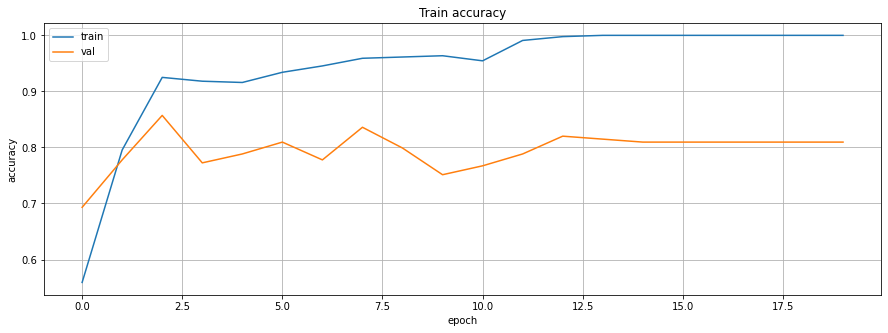

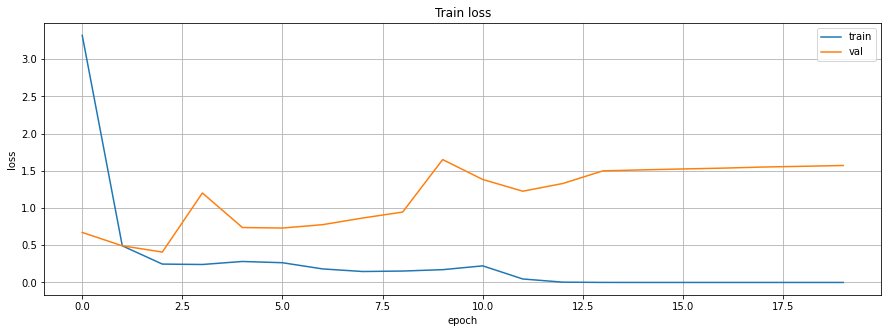

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

### Evaluate on test set

In [ ]:
# Evaluate the trained model on the test set
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

9/9 [==============================] - 1s 150ms/step - loss: 5.0481 - acc: 0.6208
['loss', 'acc']: [5.048100471496582, 0.6208178400993347]
Duration: 0:00:01.491517


### Evaluate on test set without seed

In [ ]:
# create model
img_w,img_h = 224,224 
vgg_extractor = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))
vgg_extractor.trainable = False
vgg_extractor.layers[-2].trainable = True
vgg_extractor.layers[-1].trainable = True
x = vgg_extractor.output

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)

#train model without seed
alpha = 0.001
model.compile( loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adamax(learning_rate = alpha) , metrics=["acc"] )

start_time = datetime.now()
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)

history = model.fit( x_train , y_train, batch_size=10, epochs=10, verbose=1, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

#Evaluate on test set without seed
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/20
44/44 [==============================] - ETA: 0s - loss: 3.3192 - acc: 0.5591
Epoch 1: val_acc improved from -inf to 0.69312, saving model to weights.hdf5
44/44 [==============================] - 13s 284ms/step - loss: 3.3192 - acc: 0.5591 - val_loss: 0.6719 - val_acc: 0.6931
Epoch 2/20
44/44 [==============================] - ETA: 0s - loss: 0.4918 - acc: 0.7955
Epoch 2: val_acc improved from 0.69312 to 0.77778, saving model to weights.hdf5
44/44 [==============================] - 11s 258ms/step - loss: 0.4918 - acc: 0.7955 - val_loss: 0.4921 - val_acc: 0.7778
Epoch 3/20
44/44 [==============================] - ETA: 0s - loss: 0.2466 - acc: 0.9250
Epoch 3: val_acc improved from 0.77778 to 0.85714, saving model to weights.hdf5
44/44 [==============================] - 12s 273ms/step - loss: 0.2466 - acc: 0.9250 - val_loss: 0.4083 - val_acc: 0.8571
Epoch 4/20
44/44 [==============================] - ETA: 0s - loss: 0.2412 - acc: 0.9182
Epoch 4: val_acc did not improve from 0.8

## Inference + Prediction

In [ ]:
y_pred = model.predict(x_test)
print(y_pred.shape)

9/9 [==============================] - 2s 164ms/step
(269, 4)


In [ ]:
lst = []
for i in y_pred :
    lst.append(np.argmax(i))

type(np.array(lst))

numpy.ndarray

In [ ]:
y_test[0:10]

array([0., 1., 3., 3., 2., 1., 1., 1., 1., 3.], dtype=float32)

In [ ]:
lst[0:10]

[0, 3, 2, 3, 2, 1, 1, 1, 1, 2]

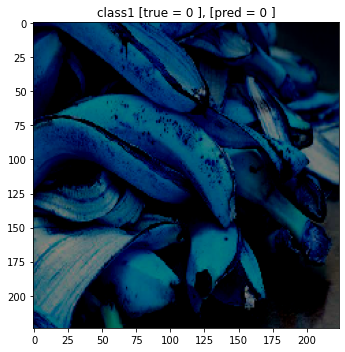

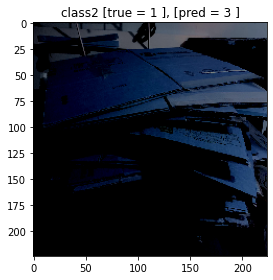

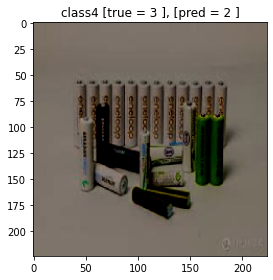

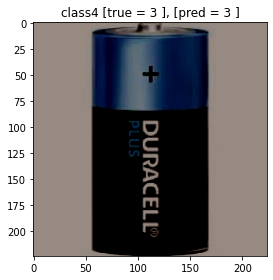

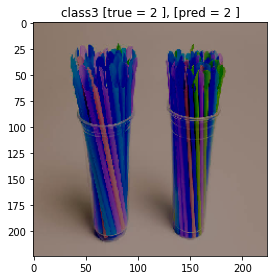

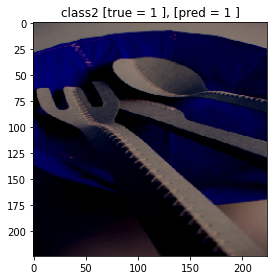

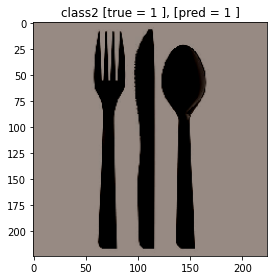

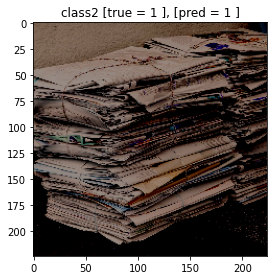

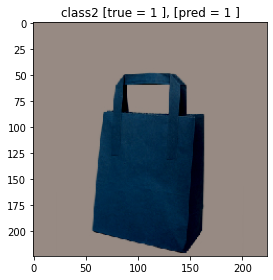

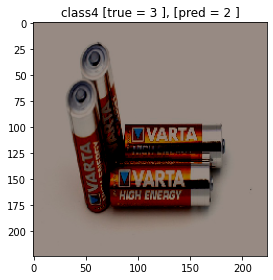

In [ ]:
# Visualize the first five images in test
plt.figure(figsize=(10,5))
for i in range(0,10):
    plt.title( f"{class_names[ int(y_test[i]) ]} [true = {int(y_test[i])} ], [pred = {lst[i]} ]") 
    plt.imshow( x_test[i] )  
    plt.tight_layout()       
    plt.show()

## Check error

In [ ]:
y_test = y_test.astype(int)
df = pd.DataFrame(list(zip(y_test, lst)), columns = ['y_test', 'y_pred'])

In [ ]:
print(df.head())

   y_test  y_pred
0       0       0
1       1       3
2       3       2
3       3       3
4       2       2


In [ ]:
index_list = df[df['y_test'] != df['y_pred']].index

In [ ]:
index_list

Int64Index([  1,   2,   9,  13,  14,  15,  16,  17,  22,  23,  24,  26,  27,
             31,  37,  39,  43,  45,  46,  56,  58,  59,  60,  64,  66,  70,
             74,  76,  77,  79,  85,  90,  97,  99, 105, 107, 109, 111, 122,
            123, 125, 126, 128, 129, 132, 141, 145, 150, 153, 160, 165, 169,
            172, 173, 174, 175, 179, 182, 183, 184, 189, 195, 196, 200, 201,
            203, 214, 217, 223, 234, 237, 241, 243, 244, 248, 250, 253, 254,
            258, 259, 260, 262, 264, 268],
           dtype='int64')

In [ ]:
len(index_list)

84

In [ ]:
df.iloc[index_list]

,y_test,y_pred
1,1,3
2,3,2
9,3,2
13,1,2
14,1,2
...,...,...
259,3,2
260,1,2
262,1,0
264,1,2


In [ ]:
# Visualize the first five images in test
plt.figure(figsize=(10,5))
for i in index_list:
    plt.title( f"{class_names[ int(y_test[i]) ]} [true = {int(y_test[i])} ], [pred = {lst[i]} ]") 
    plt.imshow( x_test[i] )  
    plt.tight_layout()       
    plt.show()

# Use tuning model DenseNet201

## Prepare pretrained Model (Tuning)

In [ ]:
img_w,img_h = 224,224 
vgg_extractor = tf.keras.applications.DenseNet201(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))

### freeze model

In [ ]:
vgg_extractor.trainable = False

### Fine tuning

In [ ]:
#vgg_extractor.layers[-2].trainable = True
#vgg_extractor.layers[-1].trainable = True

In [ ]:
for i,layer in enumerate(vgg_extractor.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_7 , trainable = False
Layer 1: name = zero_padding2d_2 , trainable = False
Layer 2: name = conv1/conv , trainable = False
Layer 3: name = conv1/bn , trainable = False
Layer 4: name = conv1/relu , trainable = False
Layer 5: name = zero_padding2d_3 , trainable = False
Layer 6: name = pool1 , trainable = False
Layer 7: name = conv2_block1_0_bn , trainable = False
Layer 8: name = conv2_block1_0_relu , trainable = False
Layer 9: name = conv2_block1_1_conv , trainable = False
Layer 10: name = conv2_block1_1_bn , trainable = False
Layer 11: name = conv2_block1_1_relu , trainable = False
Layer 12: name = conv2_block1_2_conv , trainable = False
Layer 13: name = conv2_block1_concat , trainable = False
Layer 14: name = conv2_block2_0_bn , trainable = False
Layer 15: name = conv2_block2_0_relu , trainable = False
Layer 16: name = conv2_block2_1_conv , trainable = False
Layer 17: name = conv2_block2_1_bn , trainable = False
Layer 18: name = conv2_block2_1_relu , trainable = Fa

### add classifier

In [ ]:
x = vgg_extractor.output

# Add our custom layer(s) to the end of the existing model 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model 
model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)
model.summary()

ResourceExhaustedError: ignored

In [ ]:
for i,layer in enumerate(model.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

## Train the model with transfer learning (Tuning)

In [ ]:
### edit model

np.random.seed(1234)
tf.random.set_seed(5678)

# Defining data generator withour Data Augmentation
data_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input, rescale = 1/255., validation_split = 0.3, 
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.1,
                                brightness_range=[0.8,1.2],
                                horizontal_flip=True)

train_data = data_gen.flow_from_directory(data_dir, 
                                          target_size = (224, 224), 
                                          batch_size = 700,
                                          subset = 'training',
                                          class_mode = 'binary')
test_data = data_gen.flow_from_directory(data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = 300,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 629 images belonging to 4 classes.
Found 269 images belonging to 4 classes.


In [ ]:
x_train, y_train = train_data.next()
x_test, y_test = test_data.next()

In [ ]:
alpha = 0.001
model.compile( loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adamax(learning_rate = alpha) , metrics=["acc"] )

In [ ]:
### edit model

from datetime import datetime
start_time = datetime.now()

np.random.seed(1234)
tf.random.set_seed(5678)

from keras import callbacks

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)

history = model.fit( x_train , y_train, batch_size=10, epochs=10, verbose=1, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/10
44/44 [==============================] - ETA: 0s - loss: 26.9454 - acc: 0.6159
Epoch 1: val_acc improved from -inf to 0.76720, saving model to weights.hdf5
44/44 [==============================] - 55s 902ms/step - loss: 26.9454 - acc: 0.6159 - val_loss: 1.4288 - val_acc: 0.7672
Epoch 2/10
44/44 [==============================] - ETA: 0s - loss: 0.2410 - acc: 0.9409
Epoch 2: val_acc improved from 0.76720 to 0.85714, saving model to weights.hdf5
44/44 [==============================] - 32s 740ms/step - loss: 0.2410 - acc: 0.9409 - val_loss: 0.6232 - val_acc: 0.8571
Epoch 3/10
44/44 [==============================] - ETA: 0s - loss: 0.0328 - acc: 0.9932
Epoch 3: val_acc improved from 0.85714 to 0.87302, saving model to weights.hdf5
44/44 [==============================] - 32s 740ms/step - loss: 0.0328 - acc: 0.9932 - val_loss: 0.5728 - val_acc: 0.8730
Epoch 4/10
44/44 [==============================] - ETA: 0s - loss: 0.0125 - acc: 0.9955
Epoch 4: val_acc did not improve from 0

In [ ]:
# Evaluate the trained model on the test set
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

9/9 [==============================] - 6s 379ms/step - loss: 1.2028 - acc: 0.7918
['loss', 'acc']: [1.2028374671936035, 0.7918215394020081]
Duration: 0:00:10.414181


## Evaluate on test set without seed

In [ ]:
# create model
img_w,img_h = 224,224 
vgg_extractor = tf.keras.applications.DenseNet201(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))
vgg_extractor.trainable = False
x = vgg_extractor.output

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)

#train model without seed
alpha = 0.001
model.compile( loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adamax(learning_rate = alpha) , metrics=["acc"] )

start_time = datetime.now()
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)

history = model.fit( x_train , y_train, batch_size=10, epochs=10, verbose=1, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

#Evaluate on test set without seed
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/10
44/44 [==============================] - ETA: 0s - loss: 3.3192 - acc: 0.5591
Epoch 1: val_acc improved from -inf to 0.69312, saving model to weights.hdf5
44/44 [==============================] - 13s 279ms/step - loss: 3.3192 - acc: 0.5591 - val_loss: 0.6719 - val_acc: 0.6931
Epoch 2/10
44/44 [==============================] - ETA: 0s - loss: 0.4924 - acc: 0.7932
Epoch 2: val_acc improved from 0.69312 to 0.79365, saving model to weights.hdf5
44/44 [==============================] - 12s 271ms/step - loss: 0.4924 - acc: 0.7932 - val_loss: 0.4874 - val_acc: 0.7937
Epoch 3/10
44/44 [==============================] - ETA: 0s - loss: 0.2493 - acc: 0.9114
Epoch 3: val_acc improved from 0.79365 to 0.82540, saving model to weights.hdf5
44/44 [==============================] - 12s 277ms/step - loss: 0.2493 - acc: 0.9114 - val_loss: 0.4077 - val_acc: 0.8254
Epoch 4/10
44/44 [==============================] - ETA: 0s - loss: 0.3122 - acc: 0.9068
Epoch 4: val_acc did not improve from 0.8